In [1]:
import os
import torch
import random
import torchaudio
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import Audio
from datetime import datetime
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import joblib

from torch.utils.data import DataLoader, Dataset, random_split
import librosa as lb
import librosa.display as lbd

# Dataset

In [2]:
#path
data_root = os.path.abspath(os.path.join(os.getcwd(), ".."))  # get data root path
aud_path = os.path.join(data_root, "audio")  # flower data set path
assert os.path.exists(aud_path), "{} path does not exist.".format(aud_path)

In [3]:
"""Generate metadata"""
def get_meta(path):
    metadate = []
    label_list = os.listdir(path)
    for i,label in enumerate(label_list):
        label_path = os.path.join(path,label)
        aud_list = os.listdir(label_path)
        for j, aud in enumerate(aud_list):
            aud_path = os.path.join(label_path,aud)
            metadate.append([aud,aud_path,label,i])
    df = pd.DataFrame(metadate,columns=['filename','path','label','label_id'])
    
    return df

In [4]:
# get metadata
aud_meta = get_meta(aud_path)
aud_meta.head()

,filename,path,label,label_id
0,111651_1.wav,/root/autodl-tmp/Pytorch-Workbench/audio/0009/...,0009,0
1,111651_2.wav,/root/autodl-tmp/Pytorch-Workbench/audio/0009/...,0009,0
2,111654_1.wav,/root/autodl-tmp/Pytorch-Workbench/audio/0009/...,0009,0
3,111654_2.wav,/root/autodl-tmp/Pytorch-Workbench/audio/0009/...,0009,0
4,111654_3.wav,/root/autodl-tmp/Pytorch-Workbench/audio/0009/...,0009,0


In [5]:
class AudioUtil():
    
    # ----------------------------
    # Load an audio file. Return the signal as a tensor and the sample rate
    # ----------------------------
    @staticmethod
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file)
        return (sig, sr)
    # ----------------------------
    # Convert the given audio to the desired number of channels
    # ----------------------------
    @staticmethod
    def rechannel(aud, new_channel):
        sig, sr = aud

        if (sig.shape[0] == new_channel):
            # Nothing to do
            return aud

        if (new_channel == 1):
            # Convert from stereo to mono by selecting only the first channel
            resig = sig[:1, :]
        else:
            # Convert from mono to stereo by duplicating the first channel
            resig = torch.cat([sig, sig])

        return ((resig, sr))
    # ----------------------------
    # Since Resample applies to a single channel, we resample one channel at a time
    # ----------------------------
    @staticmethod
    def resample(aud, newsr):
        sig, sr = aud

        if (sr == newsr):
            # Nothing to do
            return aud

        num_channels = sig.shape[0]
        # Resample first channel
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
        if (num_channels > 1):
            # Resample the second channel and merge both channels
            retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
            resig = torch.cat([resig, retwo])

        return ((resig, newsr))
    # ----------------------------
    # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
    # ----------------------------
    @staticmethod
    def pad_trunc(aud, max_ms):
        sig, sr = aud
        num_rows, sig_len = sig.shape
        max_len = sr * max_ms//1000 

        if (sig_len > max_len):
            # Truncate the signal to the given length
            sig = sig[:,:max_len]

        elif (sig_len < max_len):
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len

            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))

            sig = torch.cat((pad_begin, sig, pad_end), 1)

        return (sig, sr)
    
    # ----------------------------
    # Shifts the signal to the left or right by some percent. Values at the end
    # are 'wrapped around' to the start of the transformed signal.
    # ----------------------------
    @staticmethod
    def time_shift(aud, shift_limit):
        sig,sr = aud
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (sig.roll(shift_amt), sr)

    # ----------------------------
    # Generate a Spectrogram
    # ----------------------------
    @staticmethod
    def spectro_gram(aud, n_mels=64, n_fft=512, f_min=150, f_max=15000, hop_len=384):
        sig,sr = aud
        top_db = 80

        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = torchaudio.transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, f_min=f_min, f_max=f_max, n_mels=n_mels)(sig)

        # Convert to decibels
        spec = torchaudio.transforms.AmplitudeToDB(top_db=top_db)(spec)
        return (spec)
    # ----------------------------
    # Augment the Spectrogram by masking out some sections of it in both the frequency
    # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
    # overfitting and to help the model generalise better. The masked sections are
    # replaced with the mean value.
    # ----------------------------
    @staticmethod
    def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_specspec = torchaudio.transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
            aug_spec = torchaudio.transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

        return aug_spec

In [6]:
# data pre
DURATION = 2000
SR = 44100
CHANNEL = 2
N_MELS = 64
N_FFT = 512
F_MIN = 150
F_MAX = 15_000
HOP_LEN = int(0.75 * N_FFT)
NUM_CLASSES = int(aud_meta.label_id.max()+1)

In [7]:
"""Load Data"""
def load_data(df):
    def load_row(row):
        audio_file = str(row.path)
        
        aud = torchaudio.load(audio_file)
        reaud = AudioUtil.resample(aud, SR)# 标准化采样
        rechan = AudioUtil.rechannel(reaud, CHANNEL)#转换为 通道
        dur_aud = AudioUtil.pad_trunc(rechan, DURATION)#统一为 秒
        
        sgram = AudioUtil.spectro_gram(dur_aud, n_mels=N_MELS, n_fft=N_FFT, f_min=F_MIN, f_max=F_MAX, hop_len=HOP_LEN)

        return row.filename, sgram
    pool = joblib.Parallel(4)
    mapper = joblib.delayed(load_row)
    tasks = [mapper(row) for row in df.itertuples(False)]
    res = pool(tqdm(tasks))
    res = dict(res)
    return res

In [8]:
# read memory
dataset = load_data(aud_meta)

  0%|          | 0/14311 [00:00<?, ?it/s]

In [9]:
class BirdClefDataset(Dataset):

    def __init__(self, dataset, meta, sr=SR, is_train=True, num_classes=NUM_CLASSES, duration=DURATION):
        
        self.dataset = dataset
        self.meta = meta.copy().reset_index(drop=True)
        self.sr = sr
        self.is_train = is_train
        self.num_classes =num_classes
        self.duration = duration
        self.audio_length = self.duration*self.sr
    
    @staticmethod
    def normalize(image):
        image = image / 255.0
#         image = torch.stack([image, image, image])
        return image
    
    @staticmethod
    def Augment(image):
        # mask time and freq
        image = spectro_augment(image, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1)
        return image

    def __len__(self):
        return len(self.meta)
    
    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        image = self.dataset[row.filename]

#         image = image[np.random.choice(len(image))]
        
        image = self.normalize(image)
        
        t = row.label_id
        return image, t

In [10]:
ds = BirdClefDataset(dataset, meta=aud_meta, sr=SR, duration=DURATION)
len(ds)

14311

shape: torch.Size([2, 64, 230])


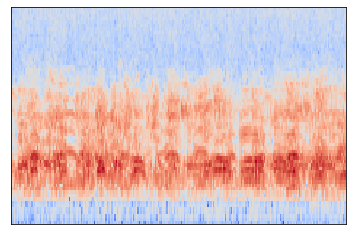

In [11]:
print("shape:", next(iter(dataset.values())).shape)
lbd.specshow(np.array(next(iter(dataset.values()))[0]))

# Dataloader

In [12]:
SPLIT = 0.8
BATCH_SIZE = 128
NUM_WORKERS = 8

In [13]:
train_size = int(len(ds)*SPLIT)  #这里train_size是一个长度矢量，并非是比例，我们将训练和测试进行8/2划分
test_size = len(ds) - train_size

train_dataset, test_dataset =random_split(ds, [train_size, test_size])
train_dataset.is_train = True
test_dataset.is_train = False
print(train_dataset.is_train,test_dataset.is_train)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

True False


# Model


![这是图片](./MobileNet.png "MobileNet 结构") 

In [14]:
from torchvision import models

In [18]:
model = models.mobilenet_v3_large(num_classes=NUM_CLASSES)

In [20]:
model.features[0][0] = nn.Conv2d(2, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Check that it is on Cuda
next(model.parameters()).device

device(type='cuda', index=0)

# Train

In [22]:
def training(model, train_dl, test_dl, num_epochs, filename):
    # criterion, Optimizer and Scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                   steps_per_epoch=int(len(train_dl)),
                                                   epochs = num_epochs,
                                                   anneal_strategy='cos')
    
    train_accs = []
    train_losses = []
    test_accs = []
    test_losses = []
    begin = datetime.now()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0

        for i, data in enumerate(train_dl):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()
            _, prediction = torch.max(outputs,1)
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

        # Print stats at the end of the epoch
        num_batches = len(train_dl)
        train_loss = running_loss / num_batches
        train_acc = correct_prediction/total_prediction
        
        train_accs.append(train_acc)
        train_losses.append(train_loss)
        
        model.eval()
        test_acc, test_loss = testing(model, test_dl)
        test_accs.append(test_acc)
        test_losses.append(test_loss)
        
        with open(filename,'a') as f:
            f.writelines(f'Epoch: {epoch}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}, \
            Test Accuracy: {test_acc:.2f}, Test loss: {test_loss:.2f}, Time: {datetime.now()-begin}\n')
            f.close()
        print(f'Epoch: {epoch}, Loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}',end=" ")
        print(f'Test Accuracy: {test_acc:.2f}, Test loss: {test_loss:.2f}, Time: {datetime.now()-begin}')
        
        

    print('Finished Training')
    return train_accs, train_losses, test_accs, test_losses

def testing (model, test_dl):
    criterion = nn.CrossEntropyLoss()
    
    correct_prediction = 0
    total_prediction = 0
    running_loss = 0.0

    with torch.no_grad():
        for data in test_dl:
            inputs, labels = data[0].to(device), data[1].to(device)
            
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, prediction = torch.max(outputs,1)
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
    
    num_batches = len(test_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    
    return acc, avg_loss

In [23]:
EPOCHS = 20

In [24]:
train_accs, train_losses, test_accs, test_losses= training(model,train_loader,test_loader,EPOCHS,"MobileNet-Large.txt")

Epoch: 0, Loss: 2.93, Accuracy: 0.10 Test Accuracy: 0.09, Test loss: 2.98, Time: 0:00:09.997909
Epoch: 1, Loss: 2.23, Accuracy: 0.30 Test Accuracy: 0.05, Test loss: 2.98, Time: 0:00:19.642501
Epoch: 2, Loss: 1.30, Accuracy: 0.60 Test Accuracy: 0.05, Test loss: 3.01, Time: 0:00:29.385830
Epoch: 3, Loss: 0.90, Accuracy: 0.73 Test Accuracy: 0.05, Test loss: 3.04, Time: 0:00:39.171321
Epoch: 4, Loss: 0.74, Accuracy: 0.78 Test Accuracy: 0.08, Test loss: 2.93, Time: 0:00:48.904623
Epoch: 5, Loss: 0.56, Accuracy: 0.83 Test Accuracy: 0.48, Test loss: 1.74, Time: 0:00:58.908173
Epoch: 6, Loss: 0.45, Accuracy: 0.87 Test Accuracy: 0.77, Test loss: 0.75, Time: 0:01:08.487032
Epoch: 7, Loss: 0.36, Accuracy: 0.89 Test Accuracy: 0.84, Test loss: 0.59, Time: 0:01:17.967419
Epoch: 8, Loss: 0.28, Accuracy: 0.92 Test Accuracy: 0.84, Test loss: 0.66, Time: 0:01:27.645611
Epoch: 9, Loss: 0.21, Accuracy: 0.94 Test Accuracy: 0.83, Test loss: 0.75, Time: 0:01:37.022162
Epoch: 10, Loss: 0.15, Accuracy: 0.95 Te

In [25]:
def result_plot(train_accs, train_losses, test_accs, test_losses):
    epochs = len(train_accs)
    
    plt.subplot(1,2,1)
    plt.plot(np.linspace(1,epochs,epochs),train_accs,label="train_acc")
    plt.plot(np.linspace(1,epochs,epochs),test_accs,label="test_acc")
    plt.title("ACC Plot")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(np.linspace(1,epochs,epochs),train_losses,label="train_loss")
    plt.plot(np.linspace(1,epochs,epochs),test_losses,label="test_loss")
    plt.title("LOSS Plot")
    plt.legend()
#     plt.savefig("acc_loss.jpg")
    plt.show()

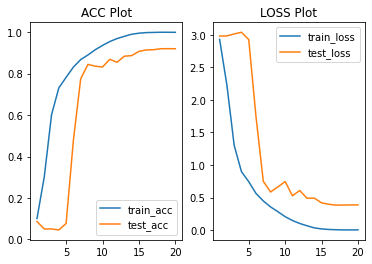

In [26]:
result_plot(train_accs, train_losses, test_accs, test_losses)